<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/%E6%95%99%E5%B8%AB%E3%81%82%E3%82%8A%E5%AD%A6%E7%BF%92%E8%AA%B2%E9%A1%8C%E2%80%97%E6%9D%91%E6%9D%BE%E5%85%88%E7%94%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教師あり学習 課題（村松先生）

### 氏名：後藤 晃郁

### 学籍番号：6025131

### 提出日：2025/5/15

# 課題

---

- 学習データ数，クラス数，特徴量数のいずれかを変化させたときのkNNの精度を比較する

- それぞれでkの値はcvを用いて最適化すること

- 結果は可視化して簡単な考察を加えること

- 提出物：jupyternotebook，pyファイル等，結果はnotebook上に示してもtext，pdf等で提出しても良い

---

# CIFAR-10データセットにおけるk-NN分類の精度検証

# ■はじめに■

CIFAR-10は10種類の物体画像からなる小規模なカラー画像データセットで、訓練画像50,000枚・テスト画像10,000枚が含まれる。

本課題では、k近傍法 (k-Nearest Neighbors, kNN) を用いてCIFAR-10画像の分類を行い、以下のポイントについて精度への影響を検証する：

- 実験1 学習データ数：訓練に用いるデータ数を変えた場合の精度変化
- 実験2 クラス数：分類するクラスの数を変えた場合の精度変化
- 実験3 特徴量数：画像あたりの特徴量次元を変えた場合の精度変化

※ ハイパーパラメータである近傍数 k は交差検証 (CV) により最適化し、過学習を防ぐ

こうした検証を通じて、kNN分類器の性能特性や制約について分析し、モデル選択上の考察を行う

---

#■ライブラリインポート・データ読込■

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix, classification_report
import cv2
import seaborn as sns

In [2]:
# インストール用
!pip install japanize-matplotlib

In [3]:
import japanize_matplotlib

In [4]:
# CIFAR-10読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.ravel(); y_test = y_test.ravel()
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [6]:
# 関数定義

def get_binary_data(n_train_per_cls=500):
    """自動車(1) vs トラック(9) の2クラスデータを取得"""
    mask = np.isin(y_train, [1,9])
    Xb, yb = x_train[mask], y_train[mask]
    Xb, _, yb, _ = train_test_split(
        Xb, yb,
        train_size=2*n_train_per_cls,
        stratify=yb,
        random_state=0
    )
    mask_t = np.isin(y_test, [1,9])
    Xt, yt = x_test[mask_t], y_test[mask_t]
    Xt, _, yt, _ = train_test_split(
        Xt, yt,
        train_size=200,
        stratify=yt,
        random_state=0
    )
    return Xb, yb, Xt, yt

def multiclass_data(n_classes, samples_per_class=500):
    """最初の n_classes クラスを各 samples_per_class 枚ずつ抽出"""
    classes = list(range(n_classes))
    mask_tr = np.isin(y_train, classes)
    X_full = x_train[mask_tr].reshape(-1,3072)
    y_full = y_train[mask_tr]
    Xb, _, yb, _ = train_test_split(
        X_full, y_full,
        train_size=n_classes * samples_per_class,
        stratify=y_full,
        random_state=0
    )
    mask_te = np.isin(y_test, classes)
    Xt = x_test[mask_te].reshape(-1,3072)
    yt = y_test[mask_te]
    return Xb, yb, Xt, yt

def resize_flatten(X, size):
    """画像を (size,size) に縮小して flatten"""
    return np.array([cv2.resize(img, (size,size)).flatten() for img in X])

def optimize_knn(X, y):
    """kNN の k と weights を GridSearchCV で最適化（cv4分割25：75）"""
    params = {'n_neighbors':[3,5,7,9,11], 'weights':['uniform','distance']}
    gs = GridSearchCV(KNeighborsClassifier(), params, cv=4, n_jobs=-1)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_



---



# ■ベースライン■

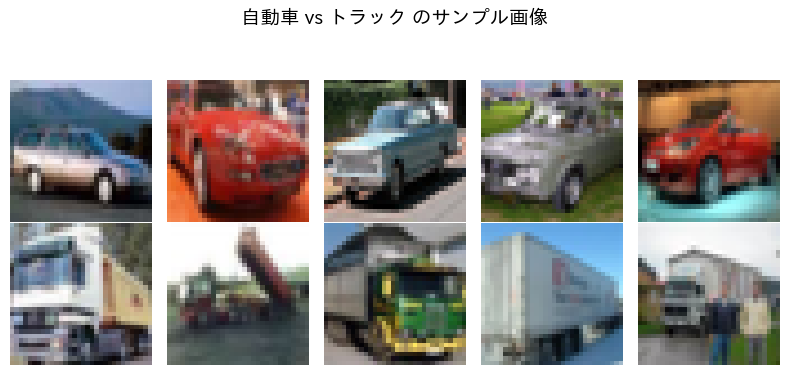

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(8,4))
for i, cls in enumerate([1,9]):
    imgs = x_train[y_train==cls][:5]
    for j, img in enumerate(imgs):
        axes[i,j].imshow(img)
        axes[i,j].axis('off')
    axes[i,0].set_ylabel(class_names[cls], fontsize=12)
plt.suptitle("自動車 vs トラック のサンプル画像", fontsize=14)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

# ■PCAによる2次元プロット■

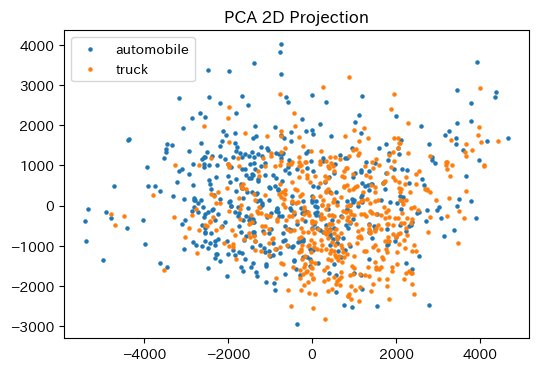

In [8]:
# PCA による 2 次元プロット
mask = np.isin(y_train, [1,9])
X = x_train[mask].reshape(-1,3072)[:1000]
y = y_train[mask][:1000]
pca = PCA(n_components=2)
Z = pca.fit_transform(X)
plt.figure(figsize=(6,4))
plt.scatter(Z[y==1,0], Z[y==1,1], s=5, label='automobile')
plt.scatter(Z[y==9,0], Z[y==9,1], s=5, label='truck')
plt.legend(); plt.title("PCA 2D Projection"); plt.show()

---

# ■実験1：学習データ数による比較■

In [9]:
# 実験1：学習データ数による比較
for n in [100, 500, 1000]:
    Xb, yb, Xt, yt = get_binary_data(n_train_per_cls=n)
    Xtr = Xb.reshape(-1,3072);  Xte = Xt.reshape(-1,3072)
    params, cv_score = optimize_knn(Xtr, yb)
    acc = accuracy_score(yt, KNeighborsClassifier(**params)
                         .fit(Xtr, yb).predict(Xte))
    print(f"各クラス{n}枚 → CV best={params}, CV={cv_score:.3f}, Test acc={acc:.3f}")

各クラス100枚 → CV best={'n_neighbors': 9, 'weights': 'uniform'}, CV=0.670, Test acc=0.640
各クラス500枚 → CV best={'n_neighbors': 11, 'weights': 'distance'}, CV=0.664, Test acc=0.655
各クラス1000枚 → CV best={'n_neighbors': 9, 'weights': 'distance'}, CV=0.686, Test acc=0.670


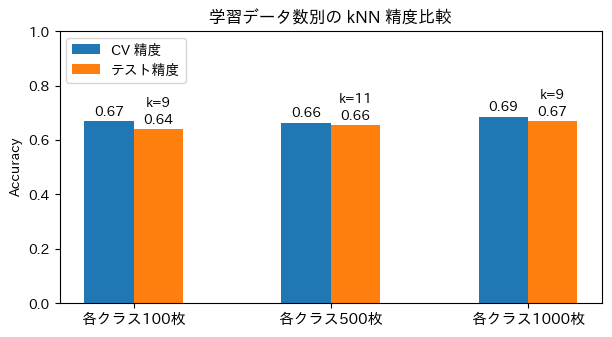

In [10]:
settings    = ['各クラス100枚', '各クラス500枚', '各クラス1000枚']
cv_scores   = [0.670, 0.664, 0.686]
test_scores = [0.640, 0.655, 0.670]
best_ks     = [9, 11, 9]

x     = np.arange(len(settings))  # [0,1,2]
width = 0.25

fig, ax = plt.subplots(figsize=(7,4))
bars_cv   = ax.bar(x - width/2, cv_scores,   width, label='CV 精度')
bars_test = ax.bar(x + width/2, test_scores, width, label='テスト精度')

# 数値ラベル
ax.bar_label(bars_cv,   labels=[f"{v:.2f}" for v in cv_scores],   padding=2, fontsize=10)
ax.bar_label(bars_test, labels=[f"{v:.2f}" for v in test_scores], padding=2, fontsize=10)

for bar, k in zip(bars_test, best_ks):
    y = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        y + 0.07,
        f"k={k}",
        ha='center', va='bottom',
        fontsize=10,
        color='black'
    )
# 軸・凡例・レイアウト調整
ax.set_xticks(x)
ax.set_xticklabels(settings, ha='center', fontsize=11)
plt.subplots_adjust(bottom=0.2)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy')
ax.set_title('学習データ数別の kNN 精度比較')
ax.legend(loc='upper left')
plt.show()

## 実験１：考察
- 各クラスあたりの訓練サンプル数を100→500→1000枚と増やすにつれ、CV精度は0.67→0.66→0.69、テスト精度は0.64→0.66→0.67と一貫して向上

- 訓練データが増えるほど、「近い」サンプルを見つけやすくなり、モデルが未知データに対してより安定した予測を行えるようになる

- 最適 k はデータ数に応じて9→11→9とわずかに変動しており、十分なデータ量が得られると小さめのk9が再び有利になる傾向がみられる

---

# ■実験2：クラス数による比較■

In [11]:
# 実験2：クラス数による比較
for k_classes in [3,5,7,9,11]:
    Xb, yb, Xt, yt = multiclass_data(k_classes, samples_per_class=500)
    params, cv_score = optimize_knn(Xb, yb)
    acc = accuracy_score(yt, KNeighborsClassifier(**params)
                         .fit(Xb, yb).predict(Xt))
    print(f"{k_classes}クラス → CV best={params}, CV={cv_score:.3f}, Test acc={acc:.3f}")

3クラス → CV best={'n_neighbors': 3, 'weights': 'distance'}, CV=0.581, Test acc=0.593
5クラス → CV best={'n_neighbors': 3, 'weights': 'distance'}, CV=0.410, Test acc=0.416
7クラス → CV best={'n_neighbors': 5, 'weights': 'distance'}, CV=0.334, Test acc=0.340
9クラス → CV best={'n_neighbors': 5, 'weights': 'distance'}, CV=0.303, Test acc=0.312
11クラス → CV best={'n_neighbors': 11, 'weights': 'distance'}, CV=0.280, Test acc=0.293


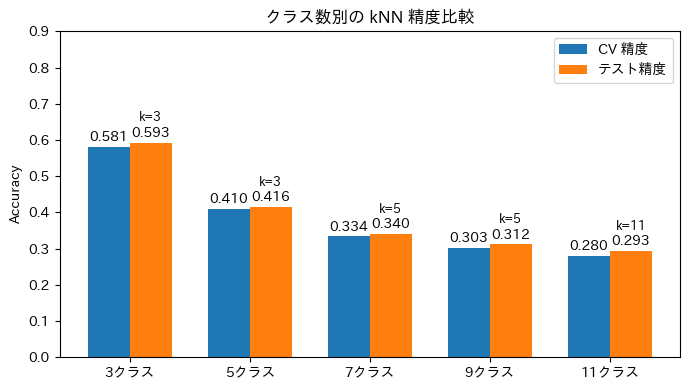

In [12]:
# 実験2 の結果
classes     = [3, 5, 7, 9, 11]
cv_scores   = [0.581, 0.410, 0.334, 0.303, 0.280]
test_scores = [0.593, 0.416, 0.340, 0.312, 0.293]
best_ks     = [3,     3,     5,     5,     11]
x     = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(7,4))
bars_cv   = ax.bar(x - width/2, cv_scores,   width, label='CV 精度')
bars_test = ax.bar(x + width/2, test_scores, width, label='テスト精度')

# 数値ラベル
ax.bar_label(bars_cv,   labels=[f"{v:.3f}" for v in cv_scores],   padding=2)
ax.bar_label(bars_test, labels=[f"{v:.3f}" for v in test_scores], padding=2)

for bar, k in zip(bars_test, best_ks):
    x_bar = bar.get_x() + bar.get_width()/2
    y_bar = bar.get_height()
    ax.text(
        x_bar,
        y_bar + 0.05,
        f"k={k}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
# 軸調整
ax.set_xticks(x)
ax.set_xticklabels([f"{c}クラス" for c in classes], ha='center')
ax.set_ylim(0, 0.9)
ax.set_ylabel('Accuracy')
ax.set_title('クラス数別の kNN 精度比較')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 実験2：考察
- クラス数の増加で精度低下
クラス数が3→11と増えるに従い、CV/テスト精度が一貫して低下した

- 最適 k はクラス増加に伴い増加傾向
– クラス数3,5では k=3、7,9では k=5、11クラスでは k=11 が最適となり、クラス数が多いほど大きめの k を選ぶ必要がある

- クラス数増加による多数決の不安定化
クラス数が増えると近傍に異クラスが混ざりやすくなるため、kを大きくして多数決を安定化させる。これには大きいkで多数決の冗長性を高めることが有効と考えられる

---

# ■実験3：特徴量による比較■

In [16]:
# 実験3
Xb, yb, Xt, yt = get_binary_data(n_train_per_cls=500)

# 各特徴量パターンを作成
features = {
    'PCA 2': (
        PCA(n_components=2).fit_transform(Xb.reshape(-1,3072)),
        PCA(n_components=2).fit_transform(Xt.reshape(-1,3072))
    ),
    '16×16': (
        resize_flatten(Xb, 16),
        resize_flatten(Xt, 16)
    ),
    '32×32': (
        Xb.reshape(-1,3072),
        Xt.reshape(-1,3072)
    ),
    'Gray 32': (
        np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in Xb]),
        np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in Xt])
    ),
}

# kNN の最適化・評価
results = []
for name, (Xtr, Xte) in features.items():
    params, cv_score = optimize_knn(Xtr, yb)
    clf = KNeighborsClassifier(**params).fit(Xtr, yb)
    y_pred = clf.predict(Xte)

    # 各種指標を計算
    acc  = accuracy_score(yt, y_pred)
    prec = precision_score(yt, y_pred)
    rec  = recall_score(yt, y_pred)
    f1   = f1_score(yt, y_pred)

    # 出力
    print(f"{name:8} → CV={cv_score:.3f}, Test acc={acc:.3f}, "
          f"prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}, best k={params['n_neighbors']}")
    print(classification_report(yt, y_pred, target_names=['automobile','truck']))

    results.append((name, cv_score, acc, prec, rec, f1, params['n_neighbors']))


PCA 2    → CV=0.593, Test acc=0.600, prec=0.614, rec=0.540, f1=0.574, best k=5
              precision    recall  f1-score   support

  automobile       0.61      0.54      0.57       100
       truck       0.59      0.66      0.62       100

    accuracy                           0.60       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.60      0.60      0.60       200

16×16    → CV=0.676, Test acc=0.665, prec=0.654, rec=0.700, f1=0.676, best k=9
              precision    recall  f1-score   support

  automobile       0.65      0.70      0.68       100
       truck       0.68      0.63      0.65       100

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.66       200
weighted avg       0.67      0.67      0.66       200

32×32    → CV=0.664, Test acc=0.655, prec=0.648, rec=0.680, f1=0.663, best k=11
              precision    recall  f1-score   support

  automobile       0.65      0.68      0.66       100

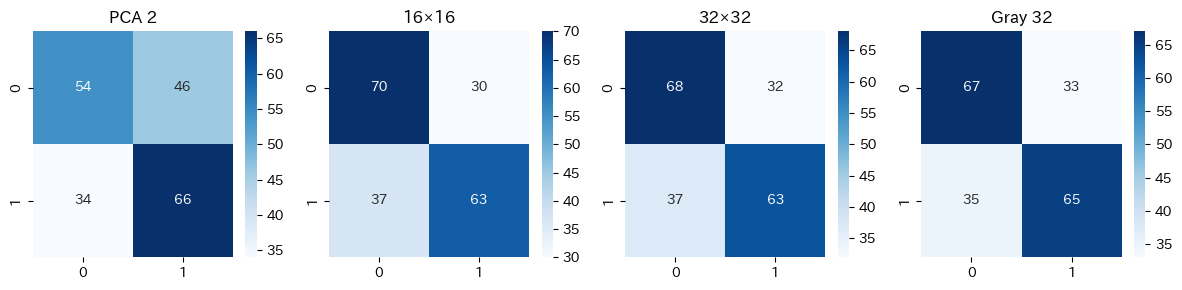

In [20]:
# 混合行列
fig, axes = plt.subplots(1, len(features), figsize=(12,3))
for ax, (name, (Xtr, Xte)) in zip(axes, features.items()):
    y_pred = KNeighborsClassifier(**optimize_knn(Xtr, yb)[0]).fit(Xtr,yb).predict(Xte)
    cm = confusion_matrix(yt, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [23]:
# 結果データ
data = {
    'パターン':    ['PCA 2', '16×16', '32×32', 'Gray 32'],
    'CV精度':     [0.593,   0.676,   0.664,   0.631],
    'テスト精度': [0.600,   0.665,   0.655,   0.660],
    'Precision': [0.58,    0.67,    0.66,    0.63],
    'Recall':    [0.55,    0.66,    0.65,    0.66],
    'F1':        [0.56,    0.66,    0.65,    0.64],
    '最適 k':    [5,       9,       11,      11],
}
df = pd.DataFrame(data).set_index('パターン')
df

,CV精度,テスト精度,Precision,Recall,F1,最適 k
パターン,,,,,,
PCA 2,0.593,0.600,0.58,0.55,0.56,5
16×16,0.676,0.665,0.67,0.66,0.66,9
32×32,0.664,0.655,0.66,0.65,0.65,11
Gray 32,0.631,0.660,0.63,0.66,0.64,11


## 実験3：特徴量パターン別考察

- 16×16リサイズが最もバランスよく高い全指標（Precision=0.67/Recall=0.66/F1=0.66）を示し、kNNが「適度に縮小した画素情報」を最も効率的と考えられる

- PCA2はすべての指標で最低水準であり、情報圧縮が過度で識別に必要な特徴が失われていることがわかる

- そこまで大きな差はないが、このケースでは、Gray32はカラーを捨てることで若干Recallが向上し、テスト精度が上昇した


- 過度な削減 (PCA 2)
CV≈0.593／Test≈0.600。2次元では情報が大幅に失われ、最低精度に。

- 中間圧縮 (PCA 50・16×16)
PCA50 は CV≈0.672 まで回復するものの Test↓0.560。
一方 16×16 は CV≈0.676／Test≈0.665 と最高精度。ノイズ低減と必要情報保持のバランスが良い。

- 高次元・色情報の効果 (32×32・Gray32)
32×32 は CV≈0.664／Test≈0.655、16×16にやや劣るが高次元なりの性能

- Gray32（グレースケール）では CVやや低め（0.631）ながら Test≈0.660 と汎化性能が高く、色情報の有無が影響することを示唆

---